In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import random
import math
import os
import warnings

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score

In [3]:
def NormalEquation(matX,vecY):
    X_transpose = np.transpose(matX)

    left_side = np.dot(X_transpose,matX)
    right_side = np.dot(X_transpose,vecY)

    ans = np.linalg.inv(left_side).dot(right_side)
    return ans

def generate_feature_matrix(x, degree):
    if degree == 0:
        X = np.ones((len(x), 1))
        return X
    elif degree == 1:
        X = np.column_stack((np.ones(len(x)), x))
        return X
    elif degree > 1:
        X_poly = np.column_stack([x ** d for d in range(0, degree)])
        return X_poly
    else:
        raise ValueError("Degree must be a non-negative integer.")

def CalculateMSE(x_positions, y_positions, w_list):
    n = len(x_positions)
    x_positions = generate_feature_matrix(x_positions,len(w_list))
    MSE = 0
    for i in range(0, n):
        wx = np.dot(x_positions[i],np.flip(w_list))
        MSE += (wx - y_positions[i]) ** 2
        
    MSE *= 1/(n)
    # print("new",MSE)
    return MSE

def testCalculateMSE(x_positions, y_positions, w_list):
    x = np.array(x_positions)
    n = len(x_positions)
    MSE = 0
    for i in range(0, n):
        wx, count = 0, 0
    for w in w_list:
        wx += w * x[i, count-1] if count > 0 else w
        count += 1
        MSE += (wx - y_positions[i]) ** 2
    MSE *= 1/(n)
    return MSE

In [4]:
warnings.simplefilter('ignore', np.RankWarning)

In [136]:
df = pd.read_csv("sin experiment/sin_noisy_10sample.csv")
print(df["noisy_y"])

0    0.1940
1   -0.1110
2   -1.1000
3   -1.2200
4   -0.1910
5    0.0903
6    0.4570
7    0.9980
8    1.3800
9    1.2100
Name: noisy_y, dtype: float64


In [6]:
k_folds = KFold(n_splits=5)

for train_index, validate_index in k_folds.split(df[["x", "x^2", "x^3"]]):
    print(train_index, validate_index)
    X_train , X_validate = df[["x", "x^2", "x^3"]].iloc[train_index],df[["x", "x^2", "x^3"]].iloc[validate_index]
    y_train , y_validate = df["y"].iloc[train_index] , df["y"].iloc[validate_index]

    new_X = [[1,1,1,1,1,1,1,1]]
    for i in np.array(X_train).transpose():
        new_X.append(list(i))
    print(new_X)
    X_matrix = np.array(new_X).transpose()
    print(X_matrix)
    print(NormalEquation(X_matrix, y_train))
    print(df[["x", "x^2", "x^3"]].shape)

[2 3 4 5 6 7 8 9] [0 1]
[[1, 1, 1, 1, 1, 1, 1, 1], [-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8], [0.36, 0.16, 0.04, 0.0, 0.04, 0.16, 0.36, 0.64], [-0.216, -0.064, -0.008, 0.0, 0.008, 0.064, 0.216, 0.512]]
[[ 1.    -0.6    0.36  -0.216]
 [ 1.    -0.4    0.16  -0.064]
 [ 1.    -0.2    0.04  -0.008]
 [ 1.     0.     0.     0.   ]
 [ 1.     0.2    0.04   0.008]
 [ 1.     0.4    0.16   0.064]
 [ 1.     0.6    0.36   0.216]
 [ 1.     0.8    0.64   0.512]]
[-0.01076204  2.92260765  0.08968369 -3.55868716]
(10, 3)
[0 1 4 5 6 7 8 9] [2 3]
[[1, 1, 1, 1, 1, 1, 1, 1], [-1.0, -0.8, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8], [1.0, 0.64, 0.04, 0.0, 0.04, 0.16, 0.36, 0.64], [-1.0, -0.512, -0.008, 0.0, 0.008, 0.064, 0.216, 0.512]]
[[ 1.    -1.     1.    -1.   ]
 [ 1.    -0.8    0.64  -0.512]
 [ 1.    -0.2    0.04  -0.008]
 [ 1.     0.     0.     0.   ]
 [ 1.     0.2    0.04   0.008]
 [ 1.     0.4    0.16   0.064]
 [ 1.     0.6    0.36   0.216]
 [ 1.     0.8    0.64   0.512]]
[ 0.03330992  2.65935653 -0.14460659 -2

In [5]:
def old_cross_validation(X, y, folds):
    #Not done
    k_folds = KFold(n_splits=folds)

    avg_rmse = []

    for train_index, validate_index in k_folds.split(X):
        #print(train_index, validate_index)
        X_train , X_validate = X.iloc[train_index], X.iloc[validate_index]
        y_train , y_validate = y.iloc[train_index] , y.iloc[validate_index]

        new_X = [[1 for i in range(X_train.shape[0])]]
        for i in np.array(X_train).transpose():
            new_X.append(list(i))
        #print(new_X)
        X_matrix = np.array(new_X).transpose()
        model = NormalEquation(X_matrix, y_train)
        #print(X_matrix)
        #print(model)
        avg_rmse.append(testCalculateMSE(np.array(X_validate), np.array(y_validate), model)**(1/2))
        #print(testCalculateMSE(np.array(X_validate), np.array(y_validate), model[0], model[1]))
    return np.mean(avg_rmse)

In [114]:
def cross_validation(X, y, folds, degree):
    k_folds = KFold(n_splits=folds)
    
    avg_rmse = []
    for train_index, validate_index in k_folds.split(X):
        # print(train_index,validate_index)
        X_train , X_validate = X.iloc[train_index], X.iloc[validate_index]
        y_train , y_validate = y.iloc[train_index], y.iloc[validate_index]

        result = np.polyfit(X_train.values.flatten(), np.array(y_train), degree)

        avg_rmse.append(CalculateMSE(X_validate.values.flatten(), np.array(y_validate), result)**(1/2))
    
    return np.average(avg_rmse)

def cross_validate_for_degree(X, y, folds, degree_list):
    column_name = list(X)
    best_degree = degree_list[0]
    rmse_list = []
    if len(column_name) == 1: return best_degree
    for degree in degree_list:
        rmse_list.append(cross_validation(X["x"], y, folds, degree))
    best_degree = degree_list[rmse_list.index(min(rmse_list))]
    return (rmse_list, best_degree)

def nested_cross_validation(X, y, folds, degree_list):
    k_folds = KFold(n_splits=folds)

    rmse_list = []

    for train_index, test_index in k_folds.split(X):
        X_train , X_test = X.iloc[train_index], X.iloc[test_index]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]

        degree = cross_validate_for_degree(X_train, y_train, min(len(X_train),folds), degree_list)[1]


        model = np.polyfit(X_train["x"].values.flatten(), np.array(y_train), degree)
        rmse_list.append(CalculateMSE(X_test["x"].values.flatten(), np.array(y_test), model)**(1/2))

    return np.average(rmse_list)

In [51]:
print(cross_validation(df[["x"]], df["noisy_y"], 10, 8))

0.8056539122602218


In [52]:
cross_validate_for_degree(df[list(df)[:-2]], df["noisy_y"], 10, range(1,9))

([0.5745319873257003,
  0.7211710931747047,
  0.2826830950955082,
  0.2908969574682363,
  0.2899368345079523,
  0.3260741216374541,
  0.9502507378553411,
  0.8056539122602218],
 3)

In [80]:
for filename in os.listdir(os.path.abspath("sin experiment")):
    path = os.path.join("sin experiment", filename)
    print(path)

    df = pd.read_csv(path)

    y = df["y"] if "noiseless" in filename else df["noisy_y"]
    #print(round(nested_cross_validation(df[list(df)[:-2]], y, 10, range(1,9)), 4))
    print(round(min(cross_validate_for_degree(df[list(df)[:-2]], y, 10, range(1,9))[0]),4))

sin experiment\sin_noiseless_10sample.csv
0.0029
sin experiment\sin_noiseless_20sample.csv
0.0012
sin experiment\sin_noiseless_40sample.csv
0.0007
sin experiment\sin_noiseless_80sample.csv
0.0005
sin experiment\sin_noisy_10sample.csv
0.3355
sin experiment\sin_noisy_20sample.csv
0.3154
sin experiment\sin_noisy_40sample.csv
0.2827
sin experiment\sin_noisy_80sample.csv
0.2987


In [137]:
cv_results = []
nested_results = []
delta_result = []
for i in range(10):
    new_df = df.sample(frac = 1, random_state=i, ignore_index=True)
    cv_result = min(cross_validate_for_degree(new_df[list(new_df)[:-2]], new_df["noisy_y"], 10, range(1,9))[0])
    nested_result = nested_cross_validation(new_df[list(new_df)[:-2]], new_df["noisy_y"], 10, range(1,9))
    print(cv_result)
    print(nested_result)
    print(nested_result - cv_result, "\n")
    cv_results.append(cv_result)
    nested_results.append(nested_result)
    delta_result.append(nested_result - cv_result)

0.3354603453225854
0.33905418351142347
0.003593838188838072 

0.3354603453225857
0.3390541835114241
0.0035938381888384052 

0.3354603453225863
0.3390541835114245
0.0035938381888382387 

0.3354603453225855
0.3390541835114235
0.0035938381888380166 

0.3354603453225855
0.3390541835114237
0.003593838188838183 

0.33546034532258573
0.3390541835114239
0.003593838188838183 

0.33546034532258573
0.3390541835114239
0.003593838188838183 

0.33546034532258606
0.33905418351142436
0.003593838188838294 

0.33546034532258584
0.3390541835114239
0.003593838188838072 

0.3354603453225863
0.33905418351142436
0.003593838188838072 



[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


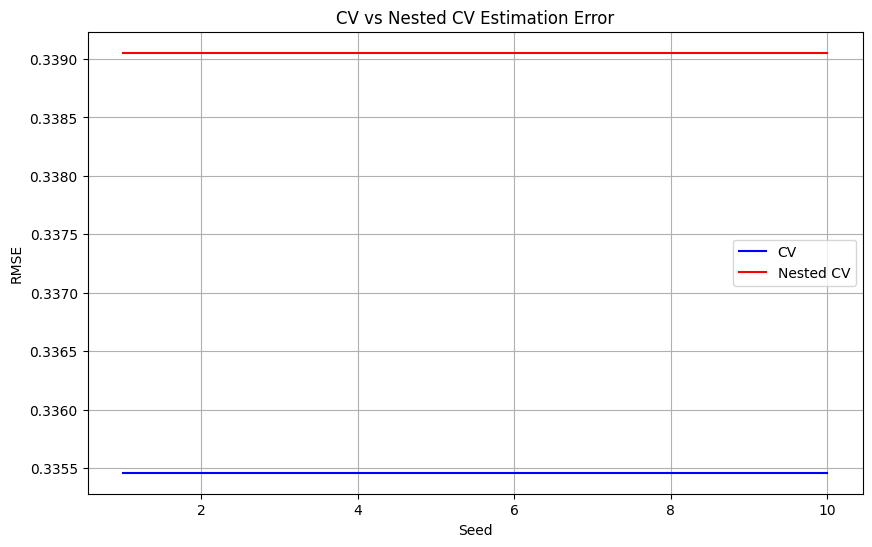

In [138]:
import matplotlib.pyplot as plt

# Generate x values for plotting
x_values = np.linspace(1, 10, 10)  # Adjust the range as needed
print(x_values)

# Evaluate the polynomial for each x value

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(x_values, cv_results, label='CV', color='blue')
plt.plot(x_values, nested_results, label='Nested CV', color='red')
plt.xlabel('Seed')
plt.ylabel('RMSE')
plt.title('CV vs Nested CV Estimation Error')
plt.legend()
plt.grid()
plt.show()

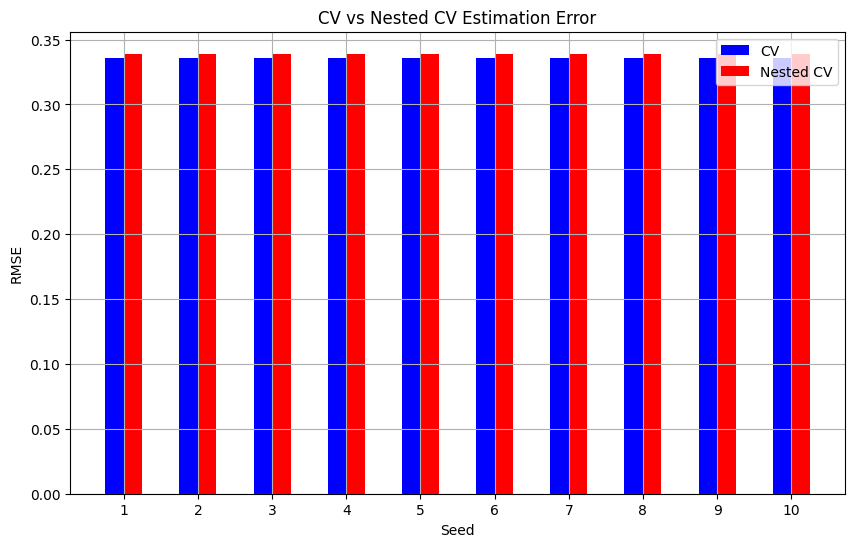

In [140]:
x_values = np.linspace(1, 10, 10)
plt.figure(figsize=(10, 6))

bar_width = 0.25

plt.bar(x_values - bar_width/2, cv_results, label='CV', color='blue', width=bar_width)
plt.bar(x_values + bar_width/2, nested_results, label='Nested CV', color='red', width=bar_width)
plt.xlabel('Seed')
plt.ylabel('RMSE')
plt.xticks(range(1,11))
plt.title('CV vs Nested CV Estimation Error')
plt.legend()
plt.grid()
plt.show()